In [1]:
import torch
from torch import nn
from monotonenorm import MonotonicLayer, GroupSort
from matplotlib import pyplot as plt

In [2]:
# Example usage
class RMSNorm(nn.Module):
    def __init__(self, norm_shape):
        super().__init__()
        self.norm_shape = torch.tensor(norm_shape)
        self.weight = nn.Parameter(torch.ones(norm_shape))
        self.bias = nn.Parameter(torch.zeros(norm_shape))
        
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, axis=-1, keepdim=True)).clip(min=1)
        return (x / rms) * self.weight + self.bias

input_dim = [3, 4, 4]
output_dim = [4, 4, 1]
model = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (
            MonotonicLayer(input_dim[i], output_dim[i]),
            GroupSort(2),
            # nn.LayerNorm(output_dim[i]),
            RMSNorm(output_dim[i]),
        )
    ][:-2]
)
model_base = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (nn.Linear(input_dim[i], output_dim[i]), GroupSort(2))
    ][:-1]
)

X = torch.randn(100, input_dim[0])
X[:, 1:] = 0
Y = model(X)
y_base = model_base(X)

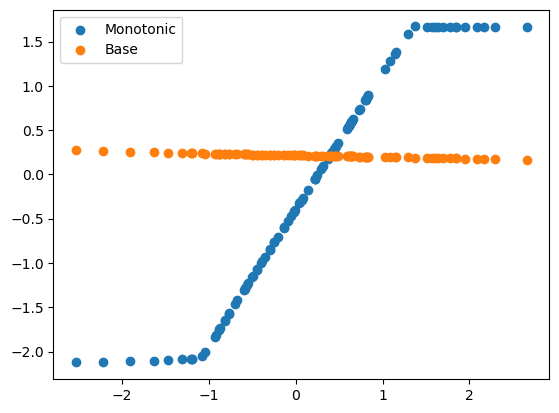

In [3]:
plt.scatter(X[:, 0], Y[:, 0].detach().numpy(), label="Monotonic")
plt.scatter(X[:, 0], y_base[:, 0].detach().numpy(), label="Base")
plt.legend()

In [4]:
x = X[:3, :]
for layer in model:
    x = layer(x)
    if isinstance(layer, MonotonicLayer):
        print(x)
        print("rms:", torch.sqrt(torch.mean(x ** 2, axis=-1)).detach())

tensor([[ 0.0256,  0.2830,  0.2188,  0.4644],
        [-0.2129, -0.0983, -0.0633,  0.2424],
        [ 0.4737,  0.9995,  0.7490,  0.8814]], grad_fn=<DivBackward0>)
rms: tensor([0.2934, 0.1716, 0.8002])
tensor([[ 0.5903,  0.3239,  0.3593,  0.2246],
        [ 0.0180, -0.3656, -0.2270, -0.2711],
        [ 1.6655,  1.6195,  1.4611,  1.1560]], grad_fn=<DivBackward0>)
rms: tensor([0.3978, 0.2545, 1.4890])
tensor([[ 0.5133],
        [-0.5936],
        [ 1.6659]], grad_fn=<DivBackward0>)
rms: tensor([0.5133, 0.5936, 1.6659])
